In [1]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


In [2]:
# Load data
data  = pd.read_pickle('../Data/sales_day_filtered.pkl')
data['date'] = pd.to_datetime(data['date'])
data.columns = ['ds', 'y']

In [3]:
# train test split
training_x = data.iloc[:int(len(data)*0.8)]
val_x = data.iloc[int(len(data)*0.8):int(len(data)*0.9)].reset_index(drop=True)
testing_x = data.iloc[int(len(data)*0.9):].reset_index(drop=True)

In [4]:
print(len(training_x))
print(len(val_x))
print(len(testing_x))

483
60
61


In [5]:
m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=0.1,seasonality_prior_scale=4, holidays_prior_scale=5, 
            changepoint_range=0.7, interval_width=0.7, uncertainty_samples=50)
m.add_country_holidays(country_name='UK')
m.fit(training_x)

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1034.98    0.00137138         39.29      0.7949      0.7949      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1036.71    0.00379946       102.273   0.0001126       0.001      240  LS failed, Hessian reset 
     199        1036.9    0.00624071       34.5148           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       1037.98   0.000271667       68.4129   5.556e-06       0.001      433  LS failed, Hessian reset 
     299       1038.15    0.00028634       41.9008       2.018      0.6672      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       1038.21   4.42841e-05        47.056   1.019e-06       0.001      534  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [6]:
future = val_x[['ds']]
future.tail()


,ds
55,2011-09-25
56,2011-09-26
57,2011-09-27
58,2011-09-28
59,2011-09-29


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
55,2011-09-25,21199.832412,15465.862748,28108.261675
56,2011-09-26,26308.532112,20050.088004,35283.436917
57,2011-09-27,27646.861309,20430.295197,31956.165326
58,2011-09-28,28288.452074,22532.818110,32822.245581
59,2011-09-29,30905.886267,23924.771897,36072.148946


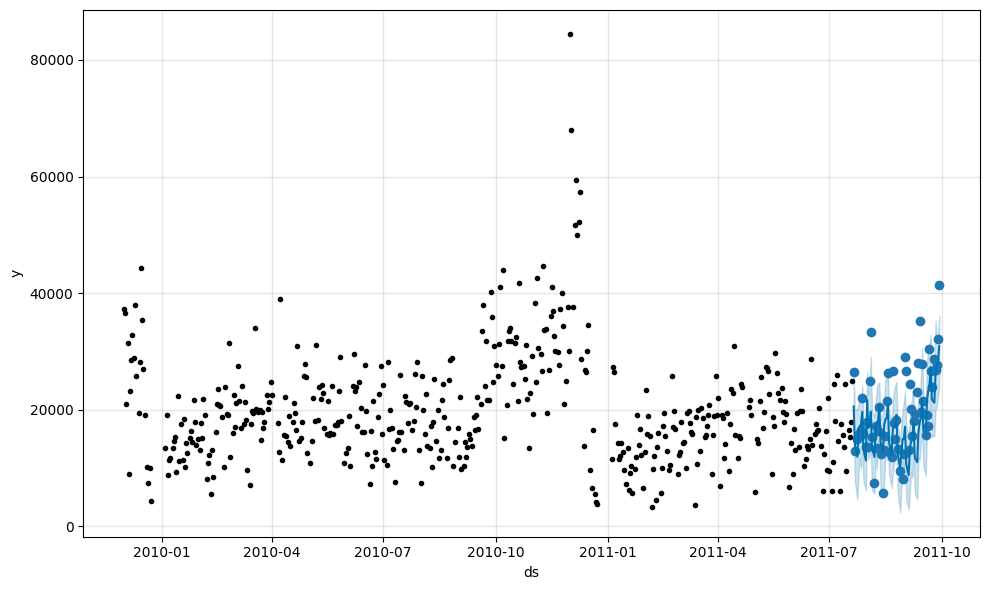

In [8]:
fig1 = m.plot(forecast)
plt.scatter(val_x['ds'], val_x['y'])

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


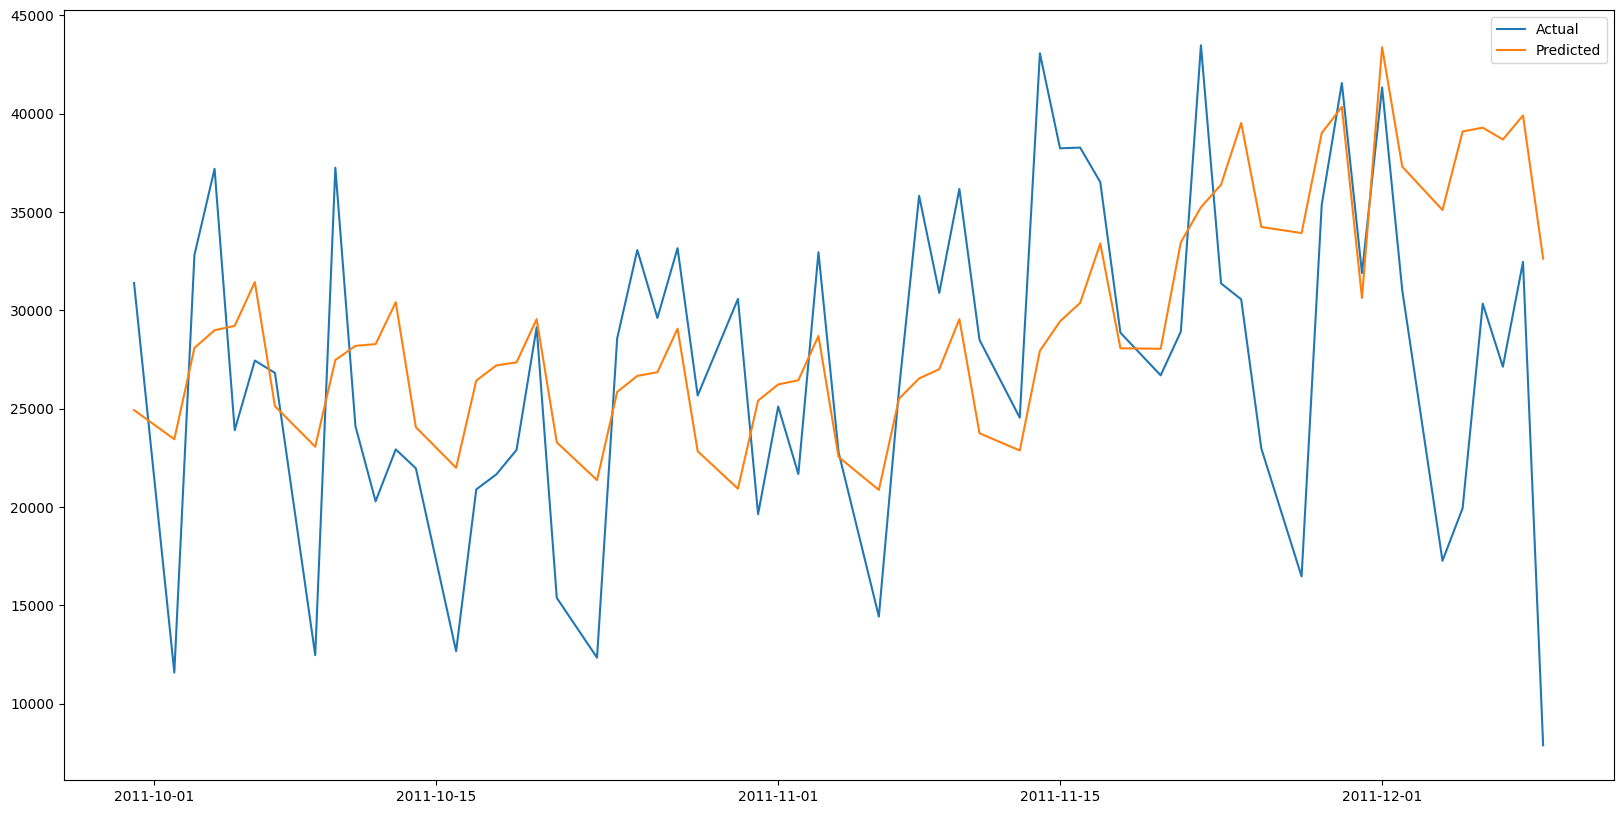

In [9]:
forecast = m.predict(testing_x[['ds']])
plt.figure(figsize=(20,10))
plt.plot(testing_x['ds'], testing_x['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

In [10]:
print("MAPE: ", mean_absolute_percentage_error(testing_x['y'], forecast['yhat']))

MAPE:  0.3203029777107304


In [11]:
def GridProphet(change_prior_scale, seasonality_prior_scale, holidays_prior_scale,changepoint_range, interval_width, uncertainty_samples):
    m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
                changepoint_prior_scale=change_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale,
                changepoint_range=changepoint_range, interval_width=interval_width, uncertainty_samples=uncertainty_samples)
    m.add_country_holidays(country_name='UK')
    m.fit(training_x,verbose=False)
    future = val_x[['ds']]
    forecast = m.predict(future)
    mape = mean_absolute_percentage_error(val_x['y'], forecast['yhat'])
    return mape

In [12]:
from sklearn.model_selection import ParameterGrid
param = {
    'change_prior_scale': [0.05,0.1,0.2], 'seasonality_prior_scale': [3,4,5], 'holidays_prior_scale': [4,5,6],
    'changepoint_range': [0.6,0.7,0.8], 'interval_width': [0.65,0.7,0.75], 'uncertainty_samples': [25,50,100]
         }
param_grid = ParameterGrid(param)

In [13]:
mape = 1
best_param = {}
for p in tqdm(param_grid):
    result = GridProphet(p['change_prior_scale'],p['seasonality_prior_scale'],p['holidays_prior_scale'], p['changepoint_range'], p['interval_width'], p['uncertainty_samples'])
    if result < mape:
        mape = result
        best_param = p
    

  0%|          | 0/729 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  0%|          | 1/729 [00:00<02:22,  5.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1029.93    0.00109682       44.8357   3.637e-05       0.001      102  LS failed, Hessian reset 
      99       1031.34     0.0216003       84.1897       0.274           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1032.58   0.000169672       52.9567   2.543e-06       0.001      271  LS failed, Hessian reset 
     199       1032.71   0.000324917       48.4963      0.3434      0.3434      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1032.72   7.70519e-05       40.6152   1.302e-06       0.001      436  LS failed, Hessian reset 
     299       1032.81   0.000630508       50.1305           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  0%|          | 2/729 [00:00<02:24,  5.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1029.93    0.00109682       44.8357   3.637e-05       0.001      102  LS failed, Hessian reset 
      99       1031.34     0.0216003       84.1897       0.274           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1032.58   0.000169672       52.9567   2.543e-06       0.001      271  LS failed, Hessian reset 
     199       1032.71   0.000324917       48.4963      0.3434      0.3434      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1032.72   7.70519e-05       40.6152   1.302e-06       0.001      436  LS failed, Hessian reset 
     299       1032.81   0.000630508       50.1305           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

  1%|          | 4/729 [00:00<02:18,  5.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 5/729 [00:00<02:11,  5.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56          1030   0.000770421       62.6085   1.027e-05       0.001      109  LS failed, Hessian reset 
      99       1031.22     0.0155169       76.3789      0.3954           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.29     0.0105176       115.177           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       1033.53   0.000224001       45.2159   4.498e-06       0.001      332  LS failed, Hessian reset 
     249       1033.84   9.88752e-05       23.5087   2.227e-06       0.001      415  LS failed, Hessian reset 
     253       1033.84   3.60821e-05       30.2777   7.899e-07       0.001      457  LS failed, Hessian reset 
     262       1033.84   3.56547e-07        42.749   1.488e-08   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 6/729 [00:01<02:12,  5.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 8/729 [00:01<02:23,  5.02it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 9/729 [00:01<02:38,  4.53it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|▏         | 10/729 [00:02<02:31,  4.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1029.93    0.00109682       44.8357   3.637e-05       0.001      102  LS failed, Hessian reset 
      99       1031.34     0.0216003       84.1897       0.274           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1032.58   0.000169672       52.9567   2.543e-06       0.001      271  LS failed, Hessian reset 
     199       1032.71   0.000324917       48.4963      0.3434      0.3434      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1032.72   7.70519e-05       40.6152   1.302e-06       0.001      436  LS failed, Hessian reset 
     299       1032.81   0.000630508       50.1305           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 11/729 [00:02<02:27,  4.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1029.93    0.00109682       44.8357   3.637e-05       0.001      102  LS failed, Hessian reset 
      99       1031.34     0.0216003       84.1897       0.274           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1032.58   0.000169672       52.9567   2.543e-06       0.001      271  LS failed, Hessian reset 
     199       1032.71   0.000324917       48.4963      0.3434      0.3434      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1032.72   7.70519e-05       40.6152   1.302e-06       0.001      436  LS failed, Hessian reset 
     299       1032.81   0.000630508       50.1305           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 14/729 [00:02<02:07,  5.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56          1030   0.000770421       62.6085   1.027e-05       0.001      109  LS failed, Hessian reset 
      99       1031.22     0.0155169       76.3789      0.3954           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.29     0.0105176       115.177           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       1033.53   0.000224001       45.2159   4.498e-06       0.001      332  LS failed, Hessian reset 
     249       1033.84   9.88752e-05       23.5087   2.227e-06       0.001      415  LS failed, Hessian reset 
     253       1033.84   3.60821e-05       30.2777   7.899e-07       0.001      457  LS failed, Hessian reset 
     262       1033.84   3.56547e-07        42.749   1.488e-08   

  2%|▏         | 15/729 [00:02<02:06,  5.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 16/729 [00:03<02:11,  5.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 17/729 [00:03<02:20,  5.08it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 18/729 [00:03<02:29,  4.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 19/729 [00:03<02:26,  4.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1029.93    0.00109682       44.8357   3.637e-05       0.001      102  LS failed, Hessian reset 
      99       1031.34     0.0216003       84.1897       0.274           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1032.58   0.000169672       52.9567   2.543e-06       0.001      271  LS failed, Hessian reset 
     199       1032.71   0.000324917       48.4963      0.3434      0.3434      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1032.72   7.70519e-05       40.6152   1.302e-06       0.001      436  LS failed, Hessian reset 
     299       1032.81   0.000630508       50.1305           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       1033.86   0.000239137  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 21/729 [00:04<02:26,  4.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1029.93    0.00109682       44.8357   3.637e-05       0.001      102  LS failed, Hessian reset 
      99       1031.34     0.0216003       84.1897       0.274           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1032.58   0.000169672       52.9567   2.543e-06       0.001      271  LS failed, Hessian reset 
     199       1032.71   0.000324917       48.4963      0.3434      0.3434      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1032.72   7.70519e-05       40.6152   1.302e-06       0.001      436  LS failed, Hessian reset 
     299       1032.81   0.000630508       50.1305           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 22/729 [00:04<02:14,  5.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56          1030   0.000770421       62.6085   1.027e-05       0.001      109  LS failed, Hessian reset 
      99       1031.22     0.0155169       76.3789      0.3954           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.29     0.0105176       115.177           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       1033.53   0.000224001       45.2159   4.498e-06       0.001      332  LS failed, Hessian reset 
     249       1033.84   9.88752e-05       23.5087   2.227e-06       0.001      415  LS failed, Hessian reset 
     253       1033.84   3.60821e-05       30.2777   7.899e-07       0.001      457  LS failed, Hessian reset 
     262       1033.84   3.56547e-07        42.749   1.488e-08   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 24/729 [00:04<02:05,  5.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.38   0.000477375       37.2594           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1036.99   9.32157e-05       81.1223   8.982e-07       0.001      567  LS failed, Hessian reset 
     399          1037   0.000666243       142.115          10           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.25   4.89504e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▎         | 26/729 [00:05<02:18,  5.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


01   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     582       1037.26   8.87125e-06       40.5445   2.133e-07       0.001      895  LS failed, Hessian reset 
     599       1037.26   2.60621e-06       34.2783           1           1      924   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     630       1037.26   6.11709e-07       55.9391      0.4525      0.4525      967   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.36    0.00144802       75.1042           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1032.9    0.00291513       64.5896      0.5418      0.5418      271   
    Iter      log pr

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▎         | 27/729 [00:05<02:28,  4.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

01   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     582       1037.26   8.87125e-06       40.5445   2.133e-07       0.001      895  LS failed, Hessian reset 
     599       1037.26   2.60621e-06       34.2783           1           1      924   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     630       1037.26   6.11709e-07       55.9391      0.4525      0.4525      967   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.11     0.0102977       56.0251           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.99   0.000446815       49.0817           1           1      258   
    Iter      log pr

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 28/729 [00:05<02:25,  4.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.11     0.0102977       56.0251           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.99   0.000446815       49.0817           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.66     0.0023046       152.905      0.3996      0.3996      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       1036.18    0.00023369       127.053   1.576e-06       0.001      487  LS failed, Hessian reset 
     399        1036.2    3.5695e-06        45.208           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411        1036.2   6.32615e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 30/729 [00:05<02:30,  4.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.41    0.00277722       68.2528           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.22     0.0182658       73.5048      0.1696           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1036.2    0.00111315        66.269           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.57   4.98981e-05       79.8176      0.9254       0.288      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.64   1.02791e-06       68.9908      0.2657      0.2657      624   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 32/729 [00:06<02:20,  4.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.41    0.00277722       68.2528           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.22     0.0182658       73.5048      0.1696           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1036.2    0.00111315        66.269           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.57   4.98981e-05       79.8176      0.9254       0.288      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.64   1.02791e-06       68.9908      0.2657      0.2657      624   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▍         | 34/729 [00:06<02:28,  4.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▍         | 36/729 [00:07<02:41,  4.28it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 37/729 [00:07<02:34,  4.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.11     0.0102977       56.0251           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.99   0.000446815       49.0817           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.66     0.0023046       152.905      0.3996      0.3996      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       1036.18    0.00023369       127.053   1.576e-06       0.001      487  LS failed, Hessian reset 
     399        1036.2    3.5695e-06        45.208           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411        1036.2   6.32615e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 38/729 [00:07<02:31,  4.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.11     0.0102977       56.0251           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.99   0.000446815       49.0817           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.66     0.0023046       152.905      0.3996      0.3996      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       1036.18    0.00023369       127.053   1.576e-06       0.001      487  LS failed, Hessian reset 
     399        1036.2    3.5695e-06        45.208           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411        1036.2   6.32615e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 40/729 [00:08<02:28,  4.65it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.41    0.00277722       68.2528           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.22     0.0182658       73.5048      0.1696           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1036.2    0.00111315        66.269           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.57   4.98981e-05       79.8176      0.9254       0.288      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.64   1.02791e-06       68.9908      0.2657      0.2657      624   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 41/729 [00:08<02:25,  4.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.41    0.00277722       68.2528           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.22     0.0182658       73.5048      0.1696           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1036.2    0.00111315        66.269           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.57   4.98981e-05       79.8176      0.9254       0.288      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.64   1.02791e-06       68.9908      0.2657      0.2657      624   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 43/729 [00:08<02:32,  4.50it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 44/729 [00:09<02:38,  4.33it/s]

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06       93.2612      0.1031      0.1031      6

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 45/729 [00:09<02:44,  4.16it/s]

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06       93.2612      0.1031      0.1031      6

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▋         | 46/729 [00:09<02:35,  4.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.11     0.0102977       56.0251           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.99   0.000446815       49.0817           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.66     0.0023046       152.905      0.3996      0.3996      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       1036.18    0.00023369       127.053   1.576e-06       0.001      487  LS failed, Hessian reset 
     399        1036.2    3.5695e-06        45.208           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411        1036.2   6.32615e-05       69.5559   1.007e-06       0.001      6

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▋         | 47/729 [00:09<02:31,  4.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.11     0.0102977       56.0251           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.99   0.000446815       49.0817           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.66     0.0023046       152.905      0.3996      0.3996      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       1036.18    0.00023369       127.053   1.576e-06       0.001      487  LS failed, Hessian reset 
     399        1036.2    3.5695e-06        45.208           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411        1036.2   6.32615e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 49/729 [00:10<02:23,  4.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.41    0.00277722       68.2528           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.22     0.0182658       73.5048      0.1696           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1036.2    0.00111315        66.269           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.57   4.98981e-05       79.8176      0.9254       0.288      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.64   1.02791e-06       68.9908      0.2657      0.2657      624   
    Iter      log prob        ||dx||      ||grad||       alpha  

  7%|▋         | 50/729 [00:10<02:19,  4.88it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 51/729 [00:10<02:19,  4.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.41    0.00277722       68.2528           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.22     0.0182658       73.5048      0.1696           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1036.2    0.00111315        66.269           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.57   4.98981e-05       79.8176      0.9254       0.288      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.64   1.02791e-06       68.9908      0.2657      0.2657      624   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 52/729 [00:10<02:24,  4.69it/s]

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06       93.2612      0.1031      0.1031      6

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 53/729 [00:10<02:29,  4.52it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.42    0.00199673       59.5296      0.5485      0.5485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1033.3    0.00999953       106.678           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1036.04   0.000136227       90.1706   1.462e-06       0.001      413  LS failed, Hessian reset 
     299       1036.17   0.000589772        76.784       4.699      0.4699      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.39   0.000637977       73.9487           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.64   4.53301e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 54/729 [00:11<02:36,  4.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

86   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     582        1036.7   7.00137e-05       47.3028   1.613e-06       0.001      823  LS failed, Hessian reset 
     598       1036.71   2.23074e-05       34.8021   4.948e-07       0.001      886  LS failed, Hessian reset 
     599       1036.71   1.14884e-05       41.8239      0.8186      0.8186      887   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     636       1036.72   1.26264e-05       56.8382   1.695e-07       0.001      985  LS failed, Hessian reset 
     674       1036.72   3.43356e-06       27.7893   4.811e-08       0.001     1076  LS failed, Hessian reset 
     698       1036.72   4.79032e-08       40.0426   1.183e-09       0.001     1150  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.64055
    Iter      log pro

  8%|▊         | 55/729 [00:11<02:22,  4.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 56/729 [00:11<02:15,  4.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1031.5    0.00194712       40.8982       0.678       0.678      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.07    0.00617769       47.1692      0.3741           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.88    0.00230018       59.2103     0.08727           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.89   0.000239208       117.301      0.8069      0.8069      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.11    1.9901e-05       97.4313      0.3821           1      638   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 57/729 [00:11<02:12,  5.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        1029.9   0.000833164       59.0267   2.578e-05       0.001       97  LS failed, Hessian reset 
      99       1031.43    0.00574881       55.1819      0.6362      0.6362      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.17     0.0210795       69.7091           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.93   0.000444771        65.691      0.3093           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1036.42   0.000105105       69.7585   2.226e-06       0.001      508  LS failed, Hessian reset 
     399        1036.6   8.08942e-05       48.1194      0.2151      0.2151      593   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 59/729 [00:12<02:11,  5.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        1029.9   0.000833164       59.0267   2.578e-05       0.001       97  LS failed, Hessian reset 
      99       1031.43    0.00574881       55.1819      0.6362      0.6362      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.17     0.0210795       69.7091           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.93   0.000444771        65.691      0.3093           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1036.42   0.000105105       69.7585   2.226e-06       0.001      508  LS failed, Hessian reset 
     399        1036.6   8.08942e-05       48.1194      0.2151      0.2151      593   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 61/729 [00:12<02:19,  4.78it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▊         | 62/729 [00:12<02:23,  4.65it/s]

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06       78.3311       0.256      0.7627      7

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▊         | 63/729 [00:13<02:29,  4.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1031.5    0.00194712       40.8982       0.678       0.678      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.07    0.00617769       47.1692      0.3741           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.88    0.00230018       59.2103     0.08727           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.89   0.000239208       117.301      0.8069      0.8069      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.11    1.9901e-05       97.4313      0.3821           1      638   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 65/729 [00:13<02:13,  4.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1031.5    0.00194712       40.8982       0.678       0.678      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.07    0.00617769       47.1692      0.3741           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.88    0.00230018       59.2103     0.08727           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.89   0.000239208       117.301      0.8069      0.8069      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.11    1.9901e-05       97.4313      0.3821           1      638   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 67/729 [00:13<02:08,  5.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        1029.9   0.000833164       59.0267   2.578e-05       0.001       97  LS failed, Hessian reset 
      99       1031.43    0.00574881       55.1819      0.6362      0.6362      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.17     0.0210795       69.7091           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.93   0.000444771        65.691      0.3093           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1036.42   0.000105105       69.7585   2.226e-06       0.001      508  LS failed, Hessian reset 
     399        1036.6   8.08942e-05       48.1194      0.2151      0.2151      593   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 69/729 [00:14<02:09,  5.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|▉         | 71/729 [00:14<02:18,  4.76it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|▉         | 72/729 [00:14<02:25,  4.52it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|█         | 73/729 [00:15<02:15,  4.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1031.5    0.00194712       40.8982       0.678       0.678      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.07    0.00617769       47.1692      0.3741           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.88    0.00230018       59.2103     0.08727           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1036.89   0.000239208       117.301      0.8069      0.8069      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1037.11    1.9901e-05       97.4313      0.3821           1      638   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|█         | 75/729 [00:15<02:10,  5.01it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        1029.9   0.000833164       59.0267   2.578e-05       0.001       97  LS failed, Hessian reset 
      99       1031.43    0.00574881       55.1819      0.6362      0.6362      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.17     0.0210795       69.7091           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.93   0.000444771        65.691      0.3093           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1036.42   0.000105105       69.7585   2.226e-06       0.001      508  LS failed, Hessian reset 
     399        1036.6   8.08942e-05       48.1194      0.2151      0.2151      593   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 77/729 [00:15<02:06,  5.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        1029.9   0.000833164       59.0267   2.578e-05       0.001       97  LS failed, Hessian reset 
      99       1031.43    0.00574881       55.1819      0.6362      0.6362      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.17     0.0210795       69.7091           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1035.93   0.000444771        65.691      0.3093           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1036.42   0.000105105       69.7585   2.226e-06       0.001      508  LS failed, Hessian reset 
     399        1036.6   8.08942e-05       48.1194      0.2151      0.2151      593   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 79/729 [00:16<02:13,  4.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 81/729 [00:16<02:23,  4.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.43    0.00100465       77.8938      0.4796      0.4796      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.63     0.0207794       80.1389           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.59   7.08928e-05       58.7748      0.7738      0.7738      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       1036.82   6.83616e-05       32.2782   1.097e-06       0.001      547  LS failed, Hessian reset 
     399       1036.83    6.4943e-07       53.6695      0.1049     0.01049      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1036.92   2.57802e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█▏        | 83/729 [00:17<01:57,  5.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.55    0.00455915       89.1314      0.4545      0.4545      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.26   4.15594e-05       45.1393      0.5669      0.5669      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       1033.77   0.000169331       42.6155   3.157e-06       0.001      396  LS failed, Hessian reset 
     299       1033.81   1.64362e-05       30.9399      0.3453      0.3453      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       1033.81   1.04958e-05        30.985   2.761e-07       0.001      502  LS failed, Hessian reset 
     319       1033.82   2.54385e-08       40.4949   8.235e-10       0.001      555  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 85/729 [00:17<01:55,  5.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.74     0.0180251       102.424           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.88     0.0681893       302.617           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.54   0.000240549       48.4501      0.2512           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1038.09    0.00156357       79.4085           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403        1038.1   8.47248e-05       74.5327   1.123e-06       0.001      550  LS failed, Hessian reset 
     499       1038.19   1.31642e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 86/729 [00:17<01:57,  5.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.74     0.0180251       102.424           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.88     0.0681893       302.617           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.54   0.000240549       48.4501      0.2512           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1038.09    0.00156357       79.4085           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403        1038.1   8.47248e-05       74.5327   1.123e-06       0.001      550  LS failed, Hessian reset 
     499       1038.19   1.31642e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 88/729 [00:17<02:01,  5.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.68      0.046804       99.1879      0.1204           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.2    0.00154701       67.0001      0.3423           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1034.26   7.34319e-05        37.836   1.258e-06       0.001      338  LS failed, Hessian reset 
     266       1034.31   1.25726e-05       45.0043   2.133e-07       0.001      449  LS failed, Hessian reset 
     299       1034.32   2.36359e-05       72.6439           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1034.35   4.61666e-05        82.067   1.143e-06       0.001      674  LS failed, Hessian reset 
     399       1034.35   8.44816e-05  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 89/729 [00:18<02:03,  5.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.68      0.046804       99.1879      0.1204           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.2    0.00154701       67.0001      0.3423           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1034.26   7.34319e-05        37.836   1.258e-06       0.001      338  LS failed, Hessian reset 
     266       1034.31   1.25726e-05       45.0043   2.133e-07       0.001      449  LS failed, Hessian reset 
     299       1034.32   2.36359e-05       72.6439           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1034.35   4.61666e-05        82.067   1.143e-06       0.001      674  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 92/729 [00:18<01:49,  5.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.55    0.00455915       89.1314      0.4545      0.4545      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.26   4.15594e-05       45.1393      0.5669      0.5669      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       1033.77   0.000169331       42.6155   3.157e-06       0.001      396  LS failed, Hessian reset 
     299       1033.81   1.64362e-05       30.9399      0.3453      0.3453      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       1033.81   1.04958e-05        30.985   2.761e-07       0.001      502  LS failed, Hessian reset 
     319       1033.82   2.54385e-08       40.4949   8.235e-10       0.001      555  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 93/729 [00:18<01:49,  5.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.74     0.0180251       102.424           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.88     0.0681893       302.617           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.54   0.000240549       48.4501      0.2512           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1038.09    0.00156357       79.4085           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403        1038.1   8.47248e-05       74.5327   1.123e-06       0.001      550  LS failed, Hessian reset 
     499       1038.19   1.31642e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 95/729 [00:19<01:54,  5.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.74     0.0180251       102.424           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.88     0.0681893       302.617           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.54   0.000240549       48.4501      0.2512           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1038.09    0.00156357       79.4085           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403        1038.1   8.47248e-05       74.5327   1.123e-06       0.001      550  LS failed, Hessian reset 
     499       1038.19   1.31642e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 97/729 [00:19<01:59,  5.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.68      0.046804       99.1879      0.1204           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.2    0.00154701       67.0001      0.3423           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1034.26   7.34319e-05        37.836   1.258e-06       0.001      338  LS failed, Hessian reset 
     266       1034.31   1.25726e-05       45.0043   2.133e-07       0.001      449  LS failed, Hessian reset 
     299       1034.32   2.36359e-05       72.6439           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1034.35   4.61666e-05        82.067   1.143e-06       0.001      674  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▎        | 99/729 [00:20<02:06,  5.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.55    0.00455915       89.1314      0.4545      0.4545      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.26   4.15594e-05       45.1393      0.5669      0.5669      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       1033.77   0.000169331       42.6155   3.157e-06       0.001      396  LS failed, Hessian reset 
     299       1033.81   1.64362e-05       30.9399      0.3453      0.3453      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       1033.81   1.04958e-05        30.985   2.761e-07       0.001      502  LS failed, Hessian reset 
     319       1033.82   2.54385e-08       40.4949   8.235e-10       0.001      555  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 102/729 [00:20<01:48,  5.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.55    0.00455915       89.1314      0.4545      0.4545      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.26   4.15594e-05       45.1393      0.5669      0.5669      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       1033.77   0.000169331       42.6155   3.157e-06       0.001      396  LS failed, Hessian reset 
     299       1033.81   1.64362e-05       30.9399      0.3453      0.3453      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       1033.81   1.04958e-05        30.985   2.761e-07       0.001      502  LS failed, Hessian reset 
     319       1033.82   2.54385e-08       40.4949   8.235e-10       0.001      555  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 103/729 [00:20<01:51,  5.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

67   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     524       1038.19   6.42513e-06       67.3161    9.36e-08       0.001      739  LS failed, Hessian reset 
     577        1038.2   2.60711e-08       65.1168      0.2004      0.2004      819   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.74     0.0180251       102.424           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.88     0.0681893       302.617           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.54   0.000240549       48.4501      0.2512           1      385   
    Iter      log pr

 14%|█▍        | 104/729 [00:20<01:53,  5.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 105/729 [00:21<02:00,  5.20it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.74     0.0180251       102.424           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.88     0.0681893       302.617           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.54   0.000240549       48.4501      0.2512           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1038.09    0.00156357       79.4085           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403        1038.1   8.47248e-05       74.5327   1.123e-06       0.001      550  LS failed, Hessian reset 
     499       1038.19   1.31642e-05    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▍        | 106/729 [00:21<02:00,  5.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.68      0.046804       99.1879      0.1204           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.2    0.00154701       67.0001      0.3423           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1034.26   7.34319e-05        37.836   1.258e-06       0.001      338  LS failed, Hessian reset 
     266       1034.31   1.25726e-05       45.0043   2.133e-07       0.001      449  LS failed, Hessian reset 
     299       1034.32   2.36359e-05       72.6439           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1034.35   4.61666e-05        82.067   1.143e-06       0.001      674  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▍        | 108/729 [00:21<02:04,  4.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.39   0.000190632        95.402      0.4693      0.4693      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1032.95   0.000436499       83.5281   6.964e-06       0.001      215  LS failed, Hessian reset 
     161       1033.04   0.000144091       39.9163   4.511e-06       0.001      273  LS failed, Hessian reset 
     199        1033.1   0.000117234       48.5649           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1033.57    0.00178072       61.8071   2.392e-05       0.001      400  LS failed, Hessian reset 
     237        1033.6   3.39977e-05       47.3118   1.009e-06       0.001      450  LS failed, Hessian reset 
     282       1033.63   2.24685e-05       32.7538   4.911e-07   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▌        | 110/729 [00:22<01:57,  5.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.39   0.000190632        95.402      0.4693      0.4693      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1032.95   0.000436499       83.5281   6.964e-06       0.001      215  LS failed, Hessian reset 
     161       1033.04   0.000144091       39.9163   4.511e-06       0.001      273  LS failed, Hessian reset 
     199        1033.1   0.000117234       48.5649           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1033.57    0.00178072       61.8071   2.392e-05       0.001      400  LS failed, Hessian reset 
     237        1033.6   3.39977e-05       47.3118   1.009e-06       0.001      450  LS failed, Hessian reset 
     282       1033.63   2.24685e-05       32.7538   4.911e-07   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▌        | 112/729 [00:22<01:52,  5.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.56     0.0625613       107.455           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        1033.3   0.000430138       52.8798   7.226e-06       0.001      195  LS failed, Hessian reset 
     175        1033.6   6.06455e-05       56.3319   1.079e-06       0.001      295  LS failed, Hessian reset 
     199       1033.65   0.000132418        41.882      0.7829      0.7829      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1033.69   5.04691e-05       60.1732   1.298e-06       0.001      417  LS failed, Hessian reset 
     243       1033.69   6.82284e-06       45.8091   1.182e-07       0.001      474  LS failed, Hessian reset 
     299       1033.72    2.1601e-07       52.6684      0.1101   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 114/729 [00:22<01:53,  5.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.81     0.0151419       89.7048       0.983       0.983      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1032.92    0.00156134       53.0437   4.128e-05       0.001      191  LS failed, Hessian reset 
     199       1033.24   0.000150236       39.8195       0.407       0.407      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.36    1.5281e-05       57.9717      0.5799      0.5799      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1033.37   3.55339e-05       27.9099   6.512e-07       0.001      517  LS failed, Hessian reset 
     322       1033.37   2.66622e-06       37.7796   6.864e-08       0.001      574  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 117/729 [00:23<01:45,  5.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.81     0.0151419       89.7048       0.983       0.983      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1032.92    0.00156134       53.0437   4.128e-05       0.001      191  LS failed, Hessian reset 
     199       1033.24   0.000150236       39.8195       0.407       0.407      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.36    1.5281e-05       57.9717      0.5799      0.5799      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1033.37   3.55339e-05       27.9099   6.512e-07       0.001      517  LS failed, Hessian reset 
     322       1033.37   2.66622e-06       37.7796   6.864e-08       0.001      574  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 118/729 [00:23<01:45,  5.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.39   0.000190632        95.402      0.4693      0.4693      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1032.95   0.000436499       83.5281   6.964e-06       0.001      215  LS failed, Hessian reset 
     161       1033.04   0.000144091       39.9163   4.511e-06       0.001      273  LS failed, Hessian reset 
     199        1033.1   0.000117234       48.5649           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1033.57    0.00178072       61.8071   2.392e-05       0.001      400  LS failed, Hessian reset 
     237        1033.6   3.39977e-05       47.3118   1.009e-06       0.001      450  LS failed, Hessian reset 
     282       1033.63   2.24685e-05       32.7538   4.911e-07   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▋        | 120/729 [00:23<01:48,  5.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.56     0.0625613       107.455           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        1033.3   0.000430138       52.8798   7.226e-06       0.001      195  LS failed, Hessian reset 
     175        1033.6   6.06455e-05       56.3319   1.079e-06       0.001      295  LS failed, Hessian reset 
     199       1033.65   0.000132418        41.882      0.7829      0.7829      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1033.69   5.04691e-05       60.1732   1.298e-06       0.001      417  LS failed, Hessian reset 
     243       1033.69   6.82284e-06       45.8091   1.182e-07       0.001      474  LS failed, Hessian reset 
     299       1033.72    2.1601e-07       52.6684      0.1101   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 123/729 [00:24<01:45,  5.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.56     0.0625613       107.455           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        1033.3   0.000430138       52.8798   7.226e-06       0.001      195  LS failed, Hessian reset 
     175        1033.6   6.06455e-05       56.3319   1.079e-06       0.001      295  LS failed, Hessian reset 
     199       1033.65   0.000132418        41.882      0.7829      0.7829      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1033.69   5.04691e-05       60.1732   1.298e-06       0.001      417  LS failed, Hessian reset 
     243       1033.69   6.82284e-06       45.8091   1.182e-07       0.001      474  LS failed, Hessian reset 
     299       1033.72    2.1601e-07       52.6684      0.1101   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 125/729 [00:24<01:36,  6.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.81     0.0151419       89.7048       0.983       0.983      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1032.92    0.00156134       53.0437   4.128e-05       0.001      191  LS failed, Hessian reset 
     199       1033.24   0.000150236       39.8195       0.407       0.407      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.36    1.5281e-05       57.9717      0.5799      0.5799      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1033.37   3.55339e-05       27.9099   6.512e-07       0.001      517  LS failed, Hessian reset 
     322       1033.37   2.66622e-06       37.7796   6.864e-08       0.001      574  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 126/729 [00:24<01:39,  6.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.39   0.000190632        95.402      0.4693      0.4693      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1032.95   0.000436499       83.5281   6.964e-06       0.001      215  LS failed, Hessian reset 
     161       1033.04   0.000144091       39.9163   4.511e-06       0.001      273  LS failed, Hessian reset 
     199        1033.1   0.000117234       48.5649           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1033.57    0.00178072       61.8071   2.392e-05       0.001      400  LS failed, Hessian reset 
     237        1033.6   3.39977e-05       47.3118   1.009e-06       0.001      450  LS failed, Hessian reset 
     282       1033.63   2.24685e-05       32.7538   4.911e-07   

 18%|█▊        | 128/729 [00:25<01:41,  5.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 129/729 [00:25<01:45,  5.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.39   0.000190632        95.402      0.4693      0.4693      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1032.95   0.000436499       83.5281   6.964e-06       0.001      215  LS failed, Hessian reset 
     161       1033.04   0.000144091       39.9163   4.511e-06       0.001      273  LS failed, Hessian reset 
     199        1033.1   0.000117234       48.5649           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1033.57    0.00178072       61.8071   2.392e-05       0.001      400  LS failed, Hessian reset 
     237        1033.6   3.39977e-05       47.3118   1.009e-06       0.001      450  LS failed, Hessian reset 
     282       1033.63   2.24685e-05       32.7538   4.911e-07   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 130/729 [00:25<01:42,  5.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.56     0.0625613       107.455           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        1033.3   0.000430138       52.8798   7.226e-06       0.001      195  LS failed, Hessian reset 
     175        1033.6   6.06455e-05       56.3319   1.079e-06       0.001      295  LS failed, Hessian reset 
     199       1033.65   0.000132418        41.882      0.7829      0.7829      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1033.69   5.04691e-05       60.1732   1.298e-06       0.001      417  LS failed, Hessian reset 
     243       1033.69   6.82284e-06       45.8091   1.182e-07       0.001      474  LS failed, Hessian reset 
     299       1033.72    2.1601e-07       52.6684      0.1101   

 18%|█▊        | 132/729 [00:25<01:45,  5.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 133/729 [00:25<01:43,  5.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.81     0.0151419       89.7048       0.983       0.983      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1032.92    0.00156134       53.0437   4.128e-05       0.001      191  LS failed, Hessian reset 
     199       1033.24   0.000150236       39.8195       0.407       0.407      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.36    1.5281e-05       57.9717      0.5799      0.5799      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1033.37   3.55339e-05       27.9099   6.512e-07       0.001      517  LS failed, Hessian reset 
     322       1033.37   2.66622e-06       37.7796   6.864e-08       0.001      574  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 134/729 [00:26<01:42,  5.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.81     0.0151419       89.7048       0.983       0.983      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1032.92    0.00156134       53.0437   4.128e-05       0.001      191  LS failed, Hessian reset 
     199       1033.24   0.000150236       39.8195       0.407       0.407      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.36    1.5281e-05       57.9717      0.5799      0.5799      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1033.37   3.55339e-05       27.9099   6.512e-07       0.001      517  LS failed, Hessian reset 
     322       1033.37   2.66622e-06       37.7796   6.864e-08       0.001      574  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▊        | 136/729 [00:26<01:51,  5.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.33      0.002672       81.4972       5.886      0.5886      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.78   0.000295918       44.6235   5.295e-06       0.001      223  LS failed, Hessian reset 
     199          1033   0.000189061       47.6666           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212          1033   1.06853e-05       33.8559   1.976e-07       0.001      365  LS failed, Hessian reset 
     271       1033.03   1.68775e-06       50.2439   4.216e-08       0.001      511  LS failed, Hessian reset 
     299       1033.04   7.48146e-07       45.5446      0.3112      0.3112      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       1033.05   1.24207e-05  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 137/729 [00:26<01:54,  5.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.33      0.002672       81.4972       5.886      0.5886      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.78   0.000295918       44.6235   5.295e-06       0.001      223  LS failed, Hessian reset 
     199          1033   0.000189061       47.6666           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212          1033   1.06853e-05       33.8559   1.976e-07       0.001      365  LS failed, Hessian reset 
     271       1033.03   1.68775e-06       50.2439   4.216e-08       0.001      511  LS failed, Hessian reset 
     299       1033.04   7.48146e-07       45.5446      0.3112      0.3112      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 139/729 [00:27<01:53,  5.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       1030.02   0.000461362       56.3697   1.353e-05       0.001      108  LS failed, Hessian reset 
      99       1032.37    0.00365719       67.7916           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.27   9.92082e-06       53.3212         1.1      0.3487      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.32   4.73367e-05       47.2061   1.554e-06       0.001      406  LS failed, Hessian reset 
     299       1033.35   4.11336e-06       52.1519      0.1332           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1033.37   8.63906e-05       33.6248   1.861e-06       0.001      585  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 141/729 [00:27<01:56,  5.05it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       1030.24      0.001122       51.1886   3.174e-05       0.001      121  LS failed, Hessian reset 
      77       1030.52   0.000536867       45.9479   8.708e-06       0.001      173  LS failed, Hessian reset 
      85       1030.59   0.000477674       43.3183   9.038e-06       0.001      218  LS failed, Hessian reset 
      99       1030.62   0.000398805       47.8634           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.65    0.00154584        61.248   3.029e-05       0.001      325  LS failed, Hessian reset 
     199       1033.25    0.00371045       64.6652      0.3863           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1033.27   0.000129755       41.3659   3.481e-06   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|█▉        | 144/729 [00:28<01:40,  5.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       1030.24      0.001122       51.1886   3.174e-05       0.001      121  LS failed, Hessian reset 
      77       1030.52   0.000536867       45.9479   8.708e-06       0.001      173  LS failed, Hessian reset 
      85       1030.59   0.000477674       43.3183   9.038e-06       0.001      218  LS failed, Hessian reset 
      99       1030.62   0.000398805       47.8634           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.65    0.00154584        61.248   3.029e-05       0.001      325  LS failed, Hessian reset 
     199       1033.25    0.00371045       64.6652      0.3863           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1033.27   0.000129755       41.3659   3.481e-06   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|█▉        | 145/729 [00:28<01:42,  5.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.33      0.002672       81.4972       5.886      0.5886      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.78   0.000295918       44.6235   5.295e-06       0.001      223  LS failed, Hessian reset 
     199          1033   0.000189061       47.6666           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212          1033   1.06853e-05       33.8559   1.976e-07       0.001      365  LS failed, Hessian reset 
     271       1033.03   1.68775e-06       50.2439   4.216e-08       0.001      511  LS failed, Hessian reset 
     299       1033.04   7.48146e-07       45.5446      0.3112      0.3112      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|██        | 147/729 [00:28<01:49,  5.32it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       1030.02   0.000461362       56.3697   1.353e-05       0.001      108  LS failed, Hessian reset 
      99       1032.37    0.00365719       67.7916           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.27   9.92082e-06       53.3212         1.1      0.3487      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.32   4.73367e-05       47.2061   1.554e-06       0.001      406  LS failed, Hessian reset 
     299       1033.35   4.11336e-06       52.1519      0.1332           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1033.37   8.63906e-05       33.6248   1.861e-06       0.001      585  LS failed, Hessian rese

 20%|██        | 149/729 [00:28<01:47,  5.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 150/729 [00:29<01:51,  5.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       1030.02   0.000461362       56.3697   1.353e-05       0.001      108  LS failed, Hessian reset 
      99       1032.37    0.00365719       67.7916           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.27   9.92082e-06       53.3212         1.1      0.3487      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.32   4.73367e-05       47.2061   1.554e-06       0.001      406  LS failed, Hessian reset 
     299       1033.35   4.11336e-06       52.1519      0.1332           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1033.37   8.63906e-05       33.6248   1.861e-06       0.001      585  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 152/729 [00:29<01:36,  5.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       1030.24      0.001122       51.1886   3.174e-05       0.001      121  LS failed, Hessian reset 
      77       1030.52   0.000536867       45.9479   8.708e-06       0.001      173  LS failed, Hessian reset 
      85       1030.59   0.000477674       43.3183   9.038e-06       0.001      218  LS failed, Hessian reset 
      99       1030.62   0.000398805       47.8634           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.65    0.00154584        61.248   3.029e-05       0.001      325  LS failed, Hessian reset 
     199       1033.25    0.00371045       64.6652      0.3863           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1033.27   0.000129755       41.3659   3.481e-06   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 154/729 [00:29<01:38,  5.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.33      0.002672       81.4972       5.886      0.5886      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.78   0.000295918       44.6235   5.295e-06       0.001      223  LS failed, Hessian reset 
     199          1033   0.000189061       47.6666           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212          1033   1.06853e-05       33.8559   1.976e-07       0.001      365  LS failed, Hessian reset 
     271       1033.03   1.68775e-06       50.2439   4.216e-08       0.001      511  LS failed, Hessian reset 
     299       1033.04   7.48146e-07       45.5446      0.3112      0.3112      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██▏       | 155/729 [00:30<01:43,  5.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.33      0.002672       81.4972       5.886      0.5886      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.78   0.000295918       44.6235   5.295e-06       0.001      223  LS failed, Hessian reset 
     199          1033   0.000189061       47.6666           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212          1033   1.06853e-05       33.8559   1.976e-07       0.001      365  LS failed, Hessian reset 
     271       1033.03   1.68775e-06       50.2439   4.216e-08       0.001      511  LS failed, Hessian reset 
     299       1033.04   7.48146e-07       45.5446      0.3112      0.3112      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 157/729 [00:30<01:47,  5.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       1030.02   0.000461362       56.3697   1.353e-05       0.001      108  LS failed, Hessian reset 
      99       1032.37    0.00365719       67.7916           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.27   9.92082e-06       53.3212         1.1      0.3487      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.32   4.73367e-05       47.2061   1.554e-06       0.001      406  LS failed, Hessian reset 
     299       1033.35   4.11336e-06       52.1519      0.1332           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1033.37   8.63906e-05       33.6248   1.861e-06       0.001      585  LS failed, Hessian reset 
     399       1033.39   9.15248e-06  

 22%|██▏       | 158/729 [00:30<01:47,  5.32it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 159/729 [00:30<01:51,  5.13it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       1030.02   0.000461362       56.3697   1.353e-05       0.001      108  LS failed, Hessian reset 
      99       1032.37    0.00365719       67.7916           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.27   9.92082e-06       53.3212         1.1      0.3487      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.32   4.73367e-05       47.2061   1.554e-06       0.001      406  LS failed, Hessian reset 
     299       1033.35   4.11336e-06       52.1519      0.1332           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1033.37   8.63906e-05       33.6248   1.861e-06       0.001      585  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 161/729 [00:31<01:36,  5.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       1030.24      0.001122       51.1886   3.174e-05       0.001      121  LS failed, Hessian reset 
      77       1030.52   0.000536867       45.9479   8.708e-06       0.001      173  LS failed, Hessian reset 
      85       1030.59   0.000477674       43.3183   9.038e-06       0.001      218  LS failed, Hessian reset 
      99       1030.62   0.000398805       47.8634           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1032.65    0.00154584        61.248   3.029e-05       0.001      325  LS failed, Hessian reset 
     199       1033.25    0.00371045       64.6652      0.3863           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1033.27   0.000129755       41.3659   3.481e-06   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 163/729 [00:31<01:39,  5.69it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.32    0.00149817       112.895   2.601e-05       0.001      124  LS failed, Hessian reset 
      99       1030.89    0.00117696       47.8793           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1031.3    0.00242457       60.8772   4.097e-05       0.001      235  LS failed, Hessian reset 
     199       1031.76    0.00368613       62.1615      0.6432           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1031.78   0.000652994       58.3099    1.05e-05       0.001      376  LS failed, Hessian reset 
     299       1032.02   5.35092e-05       45.8698           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 164/729 [00:31<01:43,  5.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.32    0.00149817       112.895   2.601e-05       0.001      124  LS failed, Hessian reset 
      99       1030.89    0.00117696       47.8793           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1031.3    0.00242457       60.8772   4.097e-05       0.001      235  LS failed, Hessian reset 
     199       1031.76    0.00368613       62.1615      0.6432           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1031.78   0.000652994       58.3099    1.05e-05       0.001      376  LS failed, Hessian reset 
     299       1032.02   5.35092e-05       45.8698           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 167/729 [00:32<01:29,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       1030.48   0.000937089       84.3131   1.445e-05       0.001      117  LS failed, Hessian reset 
      99       1030.89    0.00395734       62.5041           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       1032.85   0.000240513        43.334    3.95e-06       0.001      306  LS failed, Hessian reset 
     199       1032.87     2.468e-05       69.7752      0.3667           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1032.87   1.16607e-06       48.8978   1.886e-08       0.001      405  LS failed, Hessian reset 
     230       1032.87   8.27603e-08       57.2039           1           1      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 170/729 [00:32<01:23,  6.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       1029.77   0.000844416       88.9703   1.209e-05       0.001       96  LS failed, Hessian reset 
      60       1030.02    0.00150428       58.9054   2.897e-05       0.001      143  LS failed, Hessian reset 
      84       1030.81     0.0041207        147.12   8.166e-05       0.001      206  LS failed, Hessian reset 
      99          1031   0.000807436       52.0508      0.9093      0.9093      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1031.05   2.52037e-05       53.9255   5.105e-07       0.001      281  LS failed, Hessian reset 
     199       1032.48     0.0017573       58.2664      0.2676           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1032.63     1.633e-07       47.2811      0.5449   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 171/729 [00:32<01:25,  6.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.32    0.00149817       112.895   2.601e-05       0.001      124  LS failed, Hessian reset 
      99       1030.89    0.00117696       47.8793           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1031.3    0.00242457       60.8772   4.097e-05       0.001      235  LS failed, Hessian reset 
     199       1031.76    0.00368613       62.1615      0.6432           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1031.78   0.000652994       58.3099    1.05e-05       0.001      376  LS failed, Hessian reset 
     299       1032.02   5.35092e-05       45.8698           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▎       | 173/729 [00:33<01:34,  5.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.32    0.00149817       112.895   2.601e-05       0.001      124  LS failed, Hessian reset 
      99       1030.89    0.00117696       47.8793           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1031.3    0.00242457       60.8772   4.097e-05       0.001      235  LS failed, Hessian reset 
     199       1031.76    0.00368613       62.1615      0.6432           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1031.78   0.000652994       58.3099    1.05e-05       0.001      376  LS failed, Hessian reset 
     299       1032.02   5.35092e-05       45.8698           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 176/729 [00:33<01:25,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       1030.48   0.000937089       84.3131   1.445e-05       0.001      117  LS failed, Hessian reset 
      99       1030.89    0.00395734       62.5041           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       1032.85   0.000240513        43.334    3.95e-06       0.001      306  LS failed, Hessian reset 
     199       1032.87     2.468e-05       69.7752      0.3667           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1032.87   1.16607e-06       48.8978   1.886e-08       0.001      405  LS failed, Hessian reset 
     230       1032.87   8.27603e-08       57.2039           1           1      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 178/729 [00:33<01:21,  6.73it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       1029.77   0.000844416       88.9703   1.209e-05       0.001       96  LS failed, Hessian reset 
      60       1030.02    0.00150428       58.9054   2.897e-05       0.001      143  LS failed, Hessian reset 
      84       1030.81     0.0041207        147.12   8.166e-05       0.001      206  LS failed, Hessian reset 
      99          1031   0.000807436       52.0508      0.9093      0.9093      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1031.05   2.52037e-05       53.9255   5.105e-07       0.001      281  LS failed, Hessian reset 
     199       1032.48     0.0017573       58.2664      0.2676           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1032.63     1.633e-07       47.2811      0.5449   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▍       | 180/729 [00:34<01:24,  6.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.32    0.00149817       112.895   2.601e-05       0.001      124  LS failed, Hessian reset 
      99       1030.89    0.00117696       47.8793           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1031.3    0.00242457       60.8772   4.097e-05       0.001      235  LS failed, Hessian reset 
     199       1031.76    0.00368613       62.1615      0.6432           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1031.78   0.000652994       58.3099    1.05e-05       0.001      376  LS failed, Hessian reset 
     299       1032.02   5.35092e-05       45.8698           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▍       | 182/729 [00:34<01:33,  5.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.32    0.00149817       112.895   2.601e-05       0.001      124  LS failed, Hessian reset 
      99       1030.89    0.00117696       47.8793           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1031.3    0.00242457       60.8772   4.097e-05       0.001      235  LS failed, Hessian reset 
     199       1031.76    0.00368613       62.1615      0.6432           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1031.78   0.000652994       58.3099    1.05e-05       0.001      376  LS failed, Hessian reset 
     299       1032.02   5.35092e-05       45.8698           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▌       | 185/729 [00:35<01:25,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       1030.48   0.000937089       84.3131   1.445e-05       0.001      117  LS failed, Hessian reset 
      99       1030.89    0.00395734       62.5041           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       1032.85   0.000240513        43.334    3.95e-06       0.001      306  LS failed, Hessian reset 
     199       1032.87     2.468e-05       69.7752      0.3667           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1032.87   1.16607e-06       48.8978   1.886e-08       0.001      405  LS failed, Hessian reset 
     230       1032.87   8.27603e-08       57.2039           1           1      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probab

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 187/729 [00:35<01:22,  6.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       1029.77   0.000844416       88.9703   1.209e-05       0.001       96  LS failed, Hessian reset 
      60       1030.02    0.00150428       58.9054   2.897e-05       0.001      143  LS failed, Hessian reset 
      84       1030.81     0.0041207        147.12   8.166e-05       0.001      206  LS failed, Hessian reset 
      99          1031   0.000807436       52.0508      0.9093      0.9093      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1031.05   2.52037e-05       53.9255   5.105e-07       0.001      281  LS failed, Hessian reset 
     199       1032.48     0.0017573       58.2664      0.2676           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1032.63     1.633e-07       47.2811      0.5449   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 189/729 [00:35<01:25,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       1029.77   0.000844416       88.9703   1.209e-05       0.001       96  LS failed, Hessian reset 
      60       1030.02    0.00150428       58.9054   2.897e-05       0.001      143  LS failed, Hessian reset 
      84       1030.81     0.0041207        147.12   8.166e-05       0.001      206  LS failed, Hessian reset 
      99          1031   0.000807436       52.0508      0.9093      0.9093      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1031.05   2.52037e-05       53.9255   5.105e-07       0.001      281  LS failed, Hessian reset 
     199       1032.48     0.0017573       58.2664      0.2676           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1032.63     1.633e-07       47.2811      0.5449   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 190/729 [00:35<01:43,  5.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      alpha0  # evals  Notes 
     473       1034.82   8.49933e-05       57.5048   1.285e-06       0.001      722  LS failed, Hessian reset 
     499       1034.88   0.000295374        54.463      0.3597      0.3597      751   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     542       1034.89    2.9854e-05       74.6904   5.058e-07       0.001      856  LS failed, Hessian reset 
     599        1034.9   4.63837e-05       39.5384           1           1      935   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     602        1034.9   2.63656e-05       56.6734   4.331e-07       0.001      976  LS failed, Hessian reset 
     663        1034.9   9.44983e-06       45.5873   1.327e-07       0.001     1113  LS failed, Hessian reset 
     699        1034.9   8.78672e-06       73.4558           1           1     1160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eva

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 191/729 [00:36<01:56,  4.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.34   0.000781825        78.146   1.091e-05       0.001      121  LS failed, Hessian reset 
      99       1030.83    0.00241219       61.7277      0.3764           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1031.14   0.000866564       79.8736   1.564e-05       0.001      232  LS failed, Hessian reset 
     199       1031.64   5.38031e-05       69.5991      0.3844      0.3844      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1033    0.00156871       74.7191       0.708       0.708      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1033.5    0.00179451       65.0915           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▋       | 192/729 [00:36<02:08,  4.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.67    0.00122296       73.4904      0.4343      0.4343      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1033.52   0.000478532       42.7765   6.364e-06       0.001      250  LS failed, Hessian reset 
     199       1033.65   0.000262559       63.0688       0.259           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1033.68   3.32795e-05       51.9008   5.843e-07       0.001      366  LS failed, Hessian reset 
     299       1033.73   1.10834e-06       53.1932       1.865      0.5352      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       1033.73   3.60128e-08       51.6872      0.2364      0.2364      507   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 195/729 [00:36<01:37,  5.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.67    0.00122296       73.4904      0.4343      0.4343      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1033.52   0.000478532       42.7765   6.364e-06       0.001      250  LS failed, Hessian reset 
     199       1033.65   0.000262559       63.0688       0.259           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1033.68   3.32795e-05       51.9008   5.843e-07       0.001      366  LS failed, Hessian reset 
     299       1033.73   1.10834e-06       53.1932       1.865      0.5352      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       1033.73   3.60128e-08       51.6872      0.2364      0.2364      507   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 196/729 [00:37<01:37,  5.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.48   0.000917285       57.4177   5.739e-06       0.001      130  LS failed, Hessian reset 
      99       1030.82    0.00349647       52.1202           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1031.05   0.000635554       92.5796   7.761e-06       0.001      211  LS failed, Hessian reset 
     199       1031.75    4.3348e-05       65.7363      0.7824      0.7824      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1032.8   0.000106468       81.9403     0.05373     0.05373      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       1033.15    0.00112037        79.158   1.615e-05       0.001      507  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 198/729 [00:37<01:40,  5.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.34   0.000781825        78.146   1.091e-05       0.001      121  LS failed, Hessian reset 
      99       1030.83    0.00241219       61.7277      0.3764           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1031.14   0.000866564       79.8736   1.564e-05       0.001      232  LS failed, Hessian reset 
     199       1031.64   5.38031e-05       69.5991      0.3844      0.3844      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1033    0.00156871       74.7191       0.708       0.708      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1033.5    0.00179451       65.0915           1           1      590   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 200/729 [00:38<02:00,  4.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.34   0.000781825        78.146   1.091e-05       0.001      121  LS failed, Hessian reset 
      99       1030.83    0.00241219       61.7277      0.3764           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1031.14   0.000866564       79.8736   1.564e-05       0.001      232  LS failed, Hessian reset 
     199       1031.64   5.38031e-05       69.5991      0.3844      0.3844      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1033    0.00156871       74.7191       0.708       0.708      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1033.5    0.00179451       65.0915           1           1      590   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 203/729 [00:38<01:41,  5.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.67    0.00122296       73.4904      0.4343      0.4343      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1033.52   0.000478532       42.7765   6.364e-06       0.001      250  LS failed, Hessian reset 
     199       1033.65   0.000262559       63.0688       0.259           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1033.68   3.32795e-05       51.9008   5.843e-07       0.001      366  LS failed, Hessian reset 
     299       1033.73   1.10834e-06       53.1932       1.865      0.5352      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       1033.73   3.60128e-08       51.6872      0.2364      0.2364      507   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 204/729 [00:38<01:37,  5.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.48   0.000917285       57.4177   5.739e-06       0.001      130  LS failed, Hessian reset 
      99       1030.82    0.00349647       52.1202           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1031.05   0.000635554       92.5796   7.761e-06       0.001      211  LS failed, Hessian reset 
     199       1031.75    4.3348e-05       65.7363      0.7824      0.7824      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1032.8   0.000106468       81.9403     0.05373     0.05373      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       1033.15    0.00112037        79.158   1.615e-05       0.001      507  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 206/729 [00:39<01:35,  5.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.48   0.000917285       57.4177   5.739e-06       0.001      130  LS failed, Hessian reset 
      99       1030.82    0.00349647       52.1202           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1031.05   0.000635554       92.5796   7.761e-06       0.001      211  LS failed, Hessian reset 
     199       1031.75    4.3348e-05       65.7363      0.7824      0.7824      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1032.8   0.000106468       81.9403     0.05373     0.05373      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       1033.15    0.00112037        79.158   1.615e-05       0.001      507  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▊       | 208/729 [00:39<01:48,  4.80it/s]

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.34   0.000781825        78.146   1.091e-05       0.001      121  LS failed, Hessian reset 
      99       1030.83    0.00241219       61.7277      0.3764           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1031.14   0.000866564       79.8736   1.564e-05       0.001      232  LS failed, Hessian reset 
     199       1031.64   5.38031e-05       69.5991      0.3844      0.3844      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1033    0.00156871       74.7191       0.708       0.708      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1033.5    0.00179451       65.0915           1           1      590   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▊       | 209/729 [00:39<01:57,  4.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.34   0.000781825        78.146   1.091e-05       0.001      121  LS failed, Hessian reset 
      99       1030.83    0.00241219       61.7277      0.3764           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1031.14   0.000866564       79.8736   1.564e-05       0.001      232  LS failed, Hessian reset 
     199       1031.64   5.38031e-05       69.5991      0.3844      0.3844      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1033    0.00156871       74.7191       0.708       0.708      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1033.5    0.00179451       65.0915           1           1      590   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 212/729 [00:40<01:38,  5.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.67    0.00122296       73.4904      0.4343      0.4343      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1033.52   0.000478532       42.7765   6.364e-06       0.001      250  LS failed, Hessian reset 
     199       1033.65   0.000262559       63.0688       0.259           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1033.68   3.32795e-05       51.9008   5.843e-07       0.001      366  LS failed, Hessian reset 
     299       1033.73   1.10834e-06       53.1932       1.865      0.5352      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       1033.73   3.60128e-08       51.6872      0.2364      0.2364      507   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 214/729 [00:40<01:33,  5.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.48   0.000917285       57.4177   5.739e-06       0.001      130  LS failed, Hessian reset 
      99       1030.82    0.00349647       52.1202           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1031.05   0.000635554       92.5796   7.761e-06       0.001      211  LS failed, Hessian reset 
     199       1031.75    4.3348e-05       65.7363      0.7824      0.7824      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1032.8   0.000106468       81.9403     0.05373     0.05373      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       1033.15    0.00112037        79.158   1.615e-05       0.001      507  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 215/729 [00:40<01:34,  5.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1030.48   0.000917285       57.4177   5.739e-06       0.001      130  LS failed, Hessian reset 
      99       1030.82    0.00349647       52.1202           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1031.05   0.000635554       92.5796   7.761e-06       0.001      211  LS failed, Hessian reset 
     199       1031.75    4.3348e-05       65.7363      0.7824      0.7824      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1032.8   0.000106468       81.9403     0.05373     0.05373      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       1033.15    0.00112037        79.158   1.615e-05       0.001      507  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|██▉       | 218/729 [00:41<01:25,  5.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.47    0.00166226       72.7306   2.588e-05       0.001      123  LS failed, Hessian reset 
      99       1030.85    0.00235417       46.6052           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       1031.33    0.00101181       110.319   1.267e-05       0.001      242  LS failed, Hessian reset 
     199        1031.5   0.000195913       62.6664      0.2718           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1033.14   0.000552322       48.6704   1.109e-05       0.001      463  LS failed, Hessian reset 
     299       1033.19   1.36745e-06        48.012      0.1654      0.1654      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 30%|███       | 219/729 [00:41<01:25,  6.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|███       | 220/729 [00:41<01:21,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1031.6    0.00212473       68.8779           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.44   0.000315621       50.8218           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.89   2.07426e-07       68.1903       0.312           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       1033.89   1.66237e-06       47.9763    2.73e-08       0.001      471  LS failed, Hessian reset 
     388       1033.89   3.66317e-08       54.8534      0.2469      0.2469      540   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|███       | 222/729 [00:42<01:22,  6.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1031.6    0.00212473       68.8779           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.44   0.000315621       50.8218           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1033.89   2.07426e-07       68.1903       0.312           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       1033.89   1.66237e-06       47.9763    2.73e-08       0.001      471  LS failed, Hessian reset 
     388       1033.89   3.66317e-08       54.8534      0.2469      0.2469      540   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███       | 223/729 [00:42<01:19,  6.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       1030.44   0.000852274       94.1976   1.166e-05       0.001      138  LS failed, Hessian reset 
      99       1030.71    0.00107914       89.9189      0.1758           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1032.91    0.00189322        56.091      0.4409      0.4409      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       1033.27   0.000205575       51.7593   3.336e-06       0.001      400  LS failed, Hessian reset 
     299       1033.31   5.59047e-06       55.8072      0.9662      0.9662      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       1033.31   1.36008e-06        62.203   2.556e-08       0.001      539  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███       | 226/729 [00:42<01:17,  6.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -9.64055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       1030.47    0.00166226       72.7306   2.588e-05       0.001      123  LS failed, Hessian reset 
      99       1030.85    0.00235417       46.6052           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       1031.33    0.00101181       110.319   1.267e-05       0.001      242  LS failed, Hessian reset 
     199        1031.5   0.000195913       62.6664      0.2718           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1033.14   0.000552322       48.6704   1.109e-05       0.001      463  LS failed, Hessian reset 
     299       1033.19   1.36745e-06        48.012      0.1654      0.1654      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███▏      | 228/729 [00:42<01:17,  6.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

In [ ]:
print(mape)
print(best_param)

0.22625719622945561
{'change_prior_scale': 0.05, 'changepoint_range': 0.8, 'holidays_prior_scale': 4, 'interval_width': 0.65, 'seasonality_prior_scale': 3, 'uncertainty_samples': 25}


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -23.7188
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       752.482   1.18491e-05       102.359      0.7641      0.7641      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       752.619    0.00073488       112.186   7.053e-06       0.001      183  LS failed, Hessian reset 
     139        752.72   7.92384e-05       96.9091   7.945e-07       0.001      254  LS failed, Hessian reset 
     174       752.726   6.48227e-06       100.266   6.102e-08       0.001      345  LS failed, Hessian reset 
     199       752.727     5.174e-08        100.28      0.2598           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       752.727   4.16728e-08        92.437       0.845       0.845      383   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

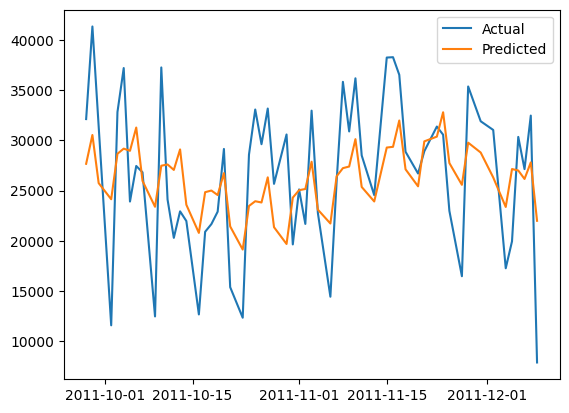

MAPE:  0.24340653877929525


In [ ]:
m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=best_param['change_prior_scale'], seasonality_prior_scale=best_param['seasonality_prior_scale'], holidays_prior_scale=best_param['holidays_prior_scale'],
            changepoint_range=best_param['changepoint_range'], interval_width=best_param['interval_width'], uncertainty_samples=best_param['uncertainty_samples']
            )
m.add_country_holidays(country_name='UK')
m.fit(training_x)
future = testing_x[['ds']]
forecast = m.predict(future)
plt.plot(testing_x['ds'], testing_x['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()
print("MAPE: ", mean_absolute_percentage_error(testing_x['y'], forecast['yhat']))

MAPE test1:  0.28441898038157704
MAPE test2:  0.20654336341304552
MAPE test3:  0.24130789462337732


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

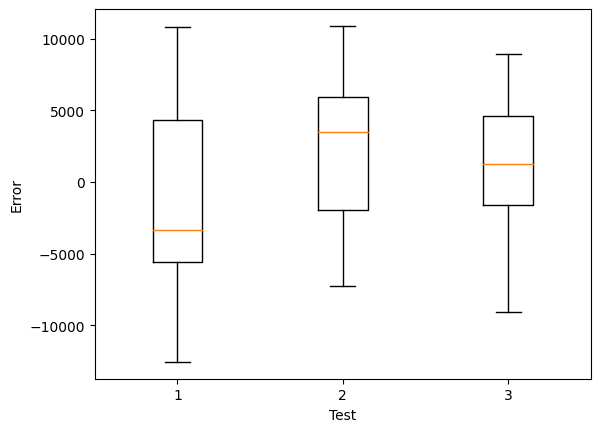

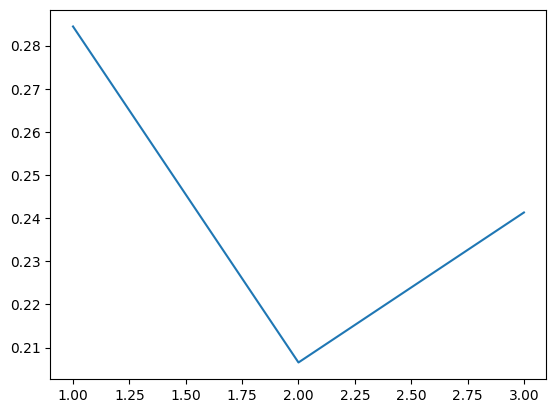

In [ ]:
# split testing data into three parts
test1 = testing_x.iloc[:int(len(testing_x)/3)].reset_index(drop=True)
test2 = testing_x.iloc[int(len(testing_x)/3):int(len(testing_x)*2/3)].reset_index(drop=True)
test3 = testing_x.iloc[int(len(testing_x)*2/3):].reset_index(drop=True)
mape_test = []
err = pd.DataFrame(columns=['test1','test2','test3'])
forecast1 = m.predict(test1[['ds']])
err['test1'] = test1['y'] - forecast1['yhat']
mape_test.append(mean_absolute_percentage_error(test1['y'], forecast1['yhat']))
print("MAPE test1: ", mean_absolute_percentage_error(test1['y'], forecast1['yhat']))

forecast2 = m.predict(test2[['ds']])
err['test2'] = test2['y'] - forecast2['yhat']
mape_test.append(mean_absolute_percentage_error(test2['y'], forecast2['yhat']))
print("MAPE test2: ", mean_absolute_percentage_error(test2['y'], forecast2['yhat']))

forecast3 = m.predict(test3[['ds']])
err['test3'] = test3['y'] - forecast3['yhat']
mape_test.append(mean_absolute_percentage_error(test3['y'], forecast3['yhat']))
print("MAPE test3: ", mean_absolute_percentage_error(test3['y'], forecast3['yhat']))

plt.boxplot(err)
plt.xlabel('Test')
plt.ylabel('Error')
plt.show()

plt.plot([1,2,3],mape_test)

/opt/homebrew/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabe

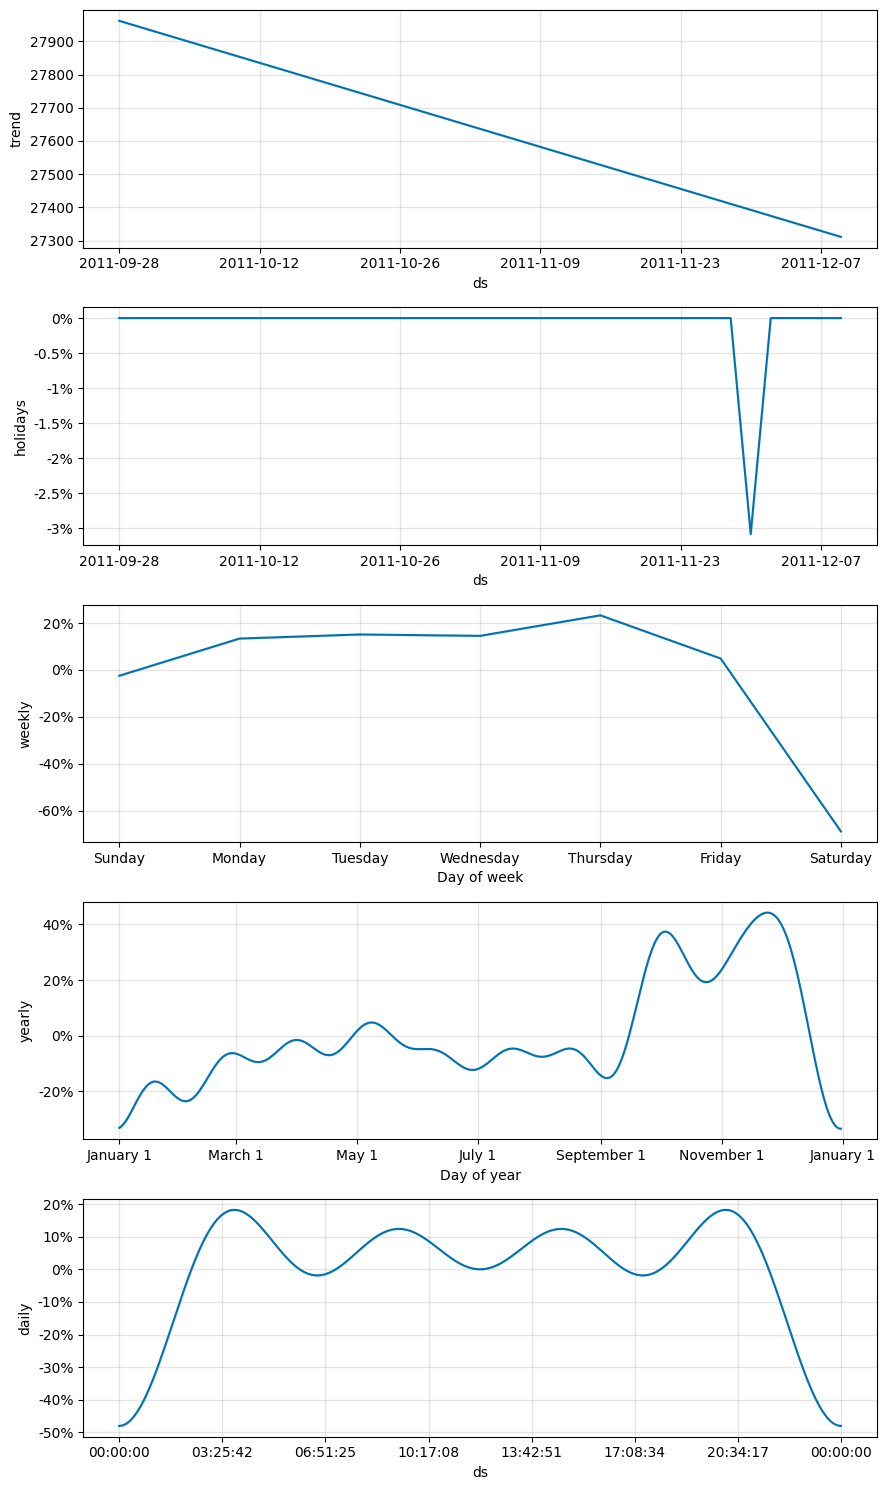

In [ ]:
fig = m.plot_components(forecast)


In [ ]:
#import pickle
#with open('../Models/prophet.pkl', 'wb') as f:
#    pickle.dump(m, f)